In [1]:
import platform
 
print(platform.python_version())

3.6.8


## This work is not my own, and I fully accredit the Keras team with the creation of this tutorial.


### Convolutional networks

This is an annotated version of Keras's [example MNIST CNN code](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) for how to implement convolutional networks.


The CIFAR-10 classification task is a classic machine learning benchmark. The data includes 50,000 images belonging to 10 classes, and the task is to identify them. Along with MNIST, CIFAR-10 classification is a sort of like a "hello world" for computer vision and convolutional networks, so a solution can be implemented quickly with an off-the-shelf machine learning library.

Since convolutional neural networks have thus far proven to be the best at computer vision tasks, we'll use the Keras library to implement a convolutional networks as our solution. Keras provides a well-designed and readable API on top of TensorFlow's backend, so we'll be done in a surprisingly short amount of steps!

Note, if you have been running these notebooks on a regular laptop without GPU until now, it's going to become more and more difficult to do so. The neural networks we will be training, starting with convolutional networks, will become increasingly memory and processing-intensive and may slow down laptops without good graphics processing. 

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten

from keras.layers import Activation


Using TensorFlow backend.


Recall that a basic neural network in Keras can be set up like this:

In [4]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_dim=3072))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________


In [5]:
from keras.datasets import cifar10

We load CIFAR-10 dataset and reshape them as individual vectors.

In [6]:
# load CIFAR
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [7]:
num_classes = 10

# reshape CIFAR
x_train = x_train.reshape(50000, 32*32*3)
x_test = x_test.reshape(10000, 32*32*3)

# make float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize to (0-1)
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('%d train samples, %d test samples'%(x_train.shape[0], x_test.shape[0]))
print("training data shape: ", x_train.shape, y_train.shape)
print("test data shape: ", x_test.shape, y_test.shape)

50000 train samples, 10000 test samples
training data shape:  (50000, 3072) (50000, 10)
test data shape:  (10000, 3072) (10000, 10)


Let's see some of our samples.

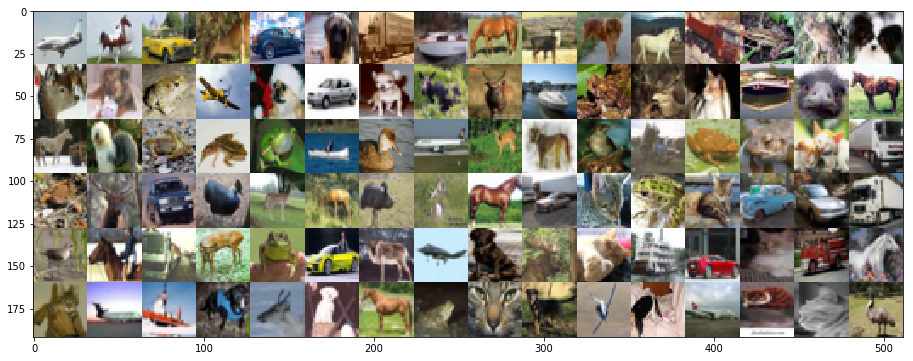

In [8]:
samples = np.concatenate([np.concatenate([x_train[i].reshape((32,32,3)) for i in [int(random.random() * len(x_train)) for i in range(16)]], axis=1) for i in range(6)], axis=0)
plt.figure(figsize=(16,6))
plt.imshow(samples, cmap='gray')

We can compile the model using categorical-cross-entropy loss, and train it for 30 epochs.

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          validation_data=(x_test, y_test))


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 2s 43us/step - loss: 2.3018 - acc: 0.1428 - val_loss: 2.2792 - val_acc: 0.1895
Epoch 2/30
50000/50000 [==============================] - 3s 55us/step - loss: 2.2668 - acc: 0.2051 - val_loss: 2.2533 - val_acc: 0.2344
Epoch 3/30
50000/50000 [==============================] - 2s 46us/step - loss: 2.2390 - acc: 0.2355 - val_loss: 2.2228 - val_acc: 0.2589
Epoch 4/30
50000/50000 [==============================] - 2s 45us/step - loss: 2.2056 - acc: 0.2490 - val_loss: 2.1868 - val_acc: 0.2731
Epoch 5/30
50000/50000 [==============================] - 2s 41us/step - loss: 2.1683 - acc: 0.2592 - val_loss: 2.1493 - val_acc: 0.2680
Epoch 6/30
50000/50000 [==============================] - 2s 44us/step - loss: 2.1318 - acc: 0.2668 - val_loss: 2.1151 - val_acc: 0.2726
Epoch 7/30
50000/50000 [==============================] - 2s 41us/step - loss: 2.1002 - acc: 0.2764 - val_loss: 2.0858 - val_acc

Then we can evaluate the model.

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.8373086441040039
Test accuracy: 0.3472


In [16]:
score

[1.8373086441040039, 0.3472]

Not very good! With more training time, perhaps 100 epochs, we might get 40% accuracy.  

Now onto convolutional networks... The general architecture of a convolutional neural network is:

- convolution layers, followed by pooling layers
- fully-connected layers
- a final fully-connected softmax layer

We'll follow this same basic structure and interweave some other components, such as [dropout](https://en.wikipedia.org/wiki/Dropout_(neural_networks), to improve performance.

To begin, we start with our convolution layers. We first need to specify some architectural hyperparemeters:

- _How many filters do we want for our convolution layers?_ Like most hyperparameters, this is chosen through a mix of intuition and tuning. A rough rule of thumb is: the more complex the task, the more filters. (Note that we don't need to have the same number of filters for each convolution layer, but we are doing so here for convenience.)
- _What size should our convolution filters be?_ We don't want filters to be too large or the resulting matrix might not be very meaningful. For instance, a useless filter size in this task would be a 28x28 filter since it covers the whole image. We also don't want filters to be too small for a similar reason, e.g. a 1x1 filter just returns each pixel.
- _What size should our pooling window be?_ Again, we don't want pooling windows to be too large or we'll be throwing away information. However, for larger images, a larger pooling window might be appropriate (same goes for convolution filters).

We start by designing a neural network with two alternating convolutional and max-pooling layers, followed by a 100-neuron fully-connected layer and a 10-neuron output. We'll have 64 and 32 filters in the two convolutional layers, and make the input shape a full-sized image (32x32x3) instead of an unrolled vector (3072x1).  We also now use ReLU activation units instead of sigmoids, to avoid vanishing gradients.

In [11]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

We need to reload the CIFAR-10 dataset and this time do *not* reshape them into unrolled input vectors -- let them stay as images, although continue to normalize them.

In [12]:
from keras.datasets import cifar10

# load CIFAR
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_classes = 10

# do not reshape CIFAR if you have a convolutional input!

# make float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# normalize to (0-1)
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('%d train samples, %d test samples'%(x_train.shape[0], x_test.shape[0]))
print("training data shape: ", x_train.shape, y_train.shape)
print("test data shape: ", x_test.shape, y_test.shape)

50000 train samples, 10000 test samples
training data shape:  (50000, 32, 32, 3) (50000, 10)
test data shape:  (10000, 32, 32, 3) (10000, 10)


Let's compile the model and test it again.

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=30,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
34816/50000 [===================>..........] - ETA: 23s - loss: 2.2276 - acc: 0.1980

Let's evaluate the model again.

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0451206232070922
Test accuracy: 0.6323


63% accuracy is a big improvement on 40%! All of that is accomplished in just 30 epochs using convolutional layers and ReLUs. 

Let's try to make the network bigger.

In [43]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_71 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
activation_72 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 8, 8, 64)          36928     
__________

Compile and train again.

In [9]:

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          36928     
__________

Evaluate test accuracy.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9820661101341247
Test accuracy: 0.6781


One problem you might notice is that the accuracy of the model is much better on the training set than on the test set. You can see that by monitoring the progress at the end of each epoch above or by evaluating it directly.

In [11]:
score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

Training loss: 0.647886616191864
Training accuracy: 0.7712


77% accuracy on the training set but only 68% on the test set. Looking at the monitored training, the validation accuracy and training accuracy began to diverge around epoch 10.

Something must be wrong!  This is a symptom of "overfitting".  Our model has probably tried to bend itself a little too well towards predicting the training set but does not generalize very well to unseen data. This is a very common problem. 

It's normal for the training accuracy to be better than the testng accuracy to some degree, because it's hard to avoid for the network to be better at predicting the data it sees. But a 9% difference is too much.

One way of helping this is by doing some regularization. We can add dropout to our model after a few layers.

In [22]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 64)        73792     
_________________________________________________________________
activation_42 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          36928     
__________

We compile and train again.

In [23]:

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.2915 - acc: 0.1272 - val_loss: 2.2643 - val_acc: 0.1780
Epoch 2/50
50000/50000 [==============================] - 6s 122us/step - loss: 2.1875 - acc: 0.1797 - val_loss: 2.0443 - val_acc: 0.2662
Epoch 3/50
50000/50000 [==============================] - 6s 121us/step - loss: 2.0504 - acc: 0.2390 - val_loss: 1.9592 - val_acc: 0.2933
Epoch 4/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.9522 - acc: 0.2873 - val_loss: 1.8107 - val_acc: 0.3590
Epoch 5/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.8516 - acc: 0.3258 - val_loss: 1.7262 - val_acc: 0.3914
Epoch 6/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7655 - acc: 0.3619 - val_loss: 1.6722 - val_acc: 0.4035
Epoch 7/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.6940 - acc: 0.3835 - val_loss: 1.5555 - 

We check our test loss and training loss again.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

Test loss: 1.5445743888854981
Test accuracy: 0.4522


Now our training accuracy is lower (72%) but our test accuracy is higher (69%).  This is more like what we expect.

In [31]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

Test loss: 0.8672016343116761
Test accuracy: 0.6991
Training loss: 0.7848990835762024
Training accuracy: 0.73034


Another way of improving performance is to experiment with different optimizers beyond just standard sgd. Let's try to instantiate the same network but use ADAM instead of sgd.

In [9]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
activation_7 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          36928     
__________

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.fit(x_train, y_train,
          batch_size=128,
          epochs=50,
          validation_data=(x_test, y_test))


ValueError: Error when checking input: expected conv2d_4_input to have 4 dimensions, but got array with shape (50000, 3072)

In [49]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

score = model.evaluate(x_train, y_train, verbose=0)
print('Training loss:', score[0])
print('Training accuracy:', score[1])

Test loss: 0.9660877988576889
Test accuracy: 0.779
Training loss: 0.024635728995651005
Training accuracy: 0.99504


78% accuracy! Our best yet. Looks heavily overfit though (99% accuracy on the training set... maybe needs more dropout?) 

Still a long way to go to beat the [record](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130) (96%).  We can make a lot of progress by making the network (much) bigger, training for (much) longer and using a lot of little tricks (like data augmentation) but that is beyond the scope of this lesson for now.

Let's also recall how to predict a single value and look at its probabilities.

predicted = 3, actual = 3


<BarContainer object of 10 artists>

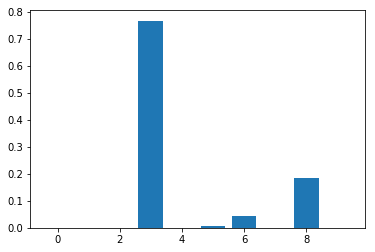

In [50]:
import matplotlib
x_sample = x_test[0].reshape(1,32,32,3)
y_prob = model.predict(x_sample)[0]
y_pred = y_prob.argmax()
y_actual = y_test[0].argmax()

print("predicted = %d, actual = %d" % (y_pred, y_actual))
matplotlib.pyplot.bar(range(10), y_prob)

Let's also review here how to save and load trained keras models. It's easy! From [Keras docuemtnation](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)

In [51]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')